<a href="https://colab.research.google.com/github/xvdp/nerf/blob/master/tiny_nerf_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tiny NeRF, a Pytorch translation

Step by step translation to pytorch
## differences between tf and pytorch that need to be minded
* tf.math.cumprod(exclusive=True) # not existent in pytorch, need to zero and roll
* i,j=tf.meshgrid('xy') -> j,i=torch.meshgrid()
* Keras Dense and torch.nn.Linear are similar with transposed weights, by default initializes w as glorot uniform and b to zero. 
* pytorch does not do automatic gpu conversion


This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook

5D input including view directions
Hierarchical Sampling

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 1.x

import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt


TensorFlow 1.x selected.


In [2]:
#xvdp
import torch
import torch.nn as nn

safelog10 = lambda x: 0 if not x else np.log10(np.abs(x))
sround = lambda x, d=1: np.round(x, max((-np.floor(safelog10(x)).astype(int) + d), 0))


In [3]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

## Load Input Images and Poses

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


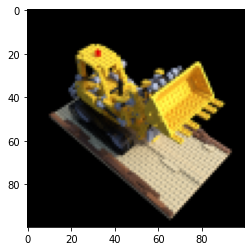

In [4]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

In [5]:
def posenc(x, L_embed=6):
    """no difference with tf"""
    rets = [x]
    for i in range(L_embed):
        for fn in [torch.sin, torch.cos]:
            rets.append(fn(2.**i * x))
    return torch.cat(rets, -1)

L_embed = 6
embed_fn = posenc

def get_rays(H, W, focal, c2w):
    """meshgroid: note instead of i,j -> j, i"""
    c2wt = torch.as_tensor(c2w)
    jt, it = torch.meshgrid(torch.arange(W, dtype=torch.float32), torch.arange(H, dtype=torch.float32))
    dirst = torch.stack([(it-W*.5)/focal, -(jt-H*.5)/focal, -torch.ones_like(it)], -1)
    rays_dt = torch.sum(dirst.view(*dirst.shape[:2], 1, -1) * c2wt[:3,:3], -1)
    rays_ot = c2wt[:3,-1] * torch.ones_like(rays_dt)
    return rays_ot, rays_dt

In [6]:
class nerf(nn.Module):
    """
    """
    def __init__(self, D=8, W=256, L_embed=6):
        super(nerf, self).__init__()
        channels = 3 + 3*2*L_embed
        self.lin0 = nn.Linear(in_features=channels, out_features=W)
        self.relu = nn.ReLU()
        block0 = []
        for i in range(1,5):
            block0 += [nn.Linear(W, W), self.relu]
        self.block0 = nn.Sequential(*block0)
    
        block1 = [nn.Linear(W+channels, W), self.relu]
        for i in range(2,4):
            block1 += [nn.Linear(W, W), self.relu]
        self.block1 = nn.Sequential(*block1)  
        self.fc = nn.Linear(W,4)
        
        # initialization needs to be explicit, pytorch default differs from keras
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
                nn.init.xavier_uniform_(m.weight, gain=1.0)

    def forward(self, x):
        x = torch.cat([self.block0(self.relu(self.lin0(x))), x], -1)
        return self.fc(self.block1(x))


In [7]:
def exclusive_cumprod(x):
    """torch cumprod does not have a exclusive=True option
        concatenate ones and roll last value out.
    """
    dim=-1
    size = list(x.shape)#
    size[dim] = 1
    ones = torch.ones(size, dtype=x.dtype, layout=x.layout, device=x.device)
    return torch.cat([ones,  torch.cumprod(x, -1)[...,:-1]], dim=dim)


In [8]:
def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False, device="cuda"):

    # sample template
    z_vals = torch.linspace(near, far, N_samples)

    # jitter sample for each ray
    if rand:
        z_vals = z_vals + torch.rand(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples

    # project directions to global jittered samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # embed, global x,y,z samples per ray to sin(x), cos(x), sin(2x), cos(2x), ...cos(x*2**i), sin(y)...
    pts_flat = embed_fn(pts.reshape(-1,3)).to(device=device)
    
    # run model in batches
    step = 32*1024
    raw = torch.cat([network_fn(pts_flat[i:i+step])
                     for i in range(0, len(pts_flat), step)]).view(list(pts.shape[:-1]) + [4])

    # Compute opacities and colors, model outputs rgba predictions
    sigma_a = nn.ReLU()(raw[...,3])
    rgb = nn.Sigmoid()(raw[...,:3]) 
                      
    # Do volume rendering
    # depth steps per ray
    dists = torch.cat([z_vals[..., 1:] - z_vals[..., :-1],
                       torch.full(z_vals[...,:1].shape, 1e10)], -1).to(device=device)

    # alpha values 
    alpha = 1.-torch.exp(-sigma_a * dists)
    weights = alpha * exclusive_cumprod(1.-alpha + 1e-10)
    
    # sum up rgb values along ray
    rgb_map = torch.sum(weights[...,None] * rgb, -2) 
    depth_map = torch.sum(weights * z_vals.to(device=device), -1) 
    acc_map = torch.sum(weights, -1)

    return rgb_map, depth_map, acc_map

In [9]:
device = "cuda"


model = nerf(D=8, W=256, L_embed=6)
N_samples = 64
model.to(device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

N_iters = 1000
psnrs = []
iternums = []
losses = []

i_plot = 100

import time


## simplified training loop

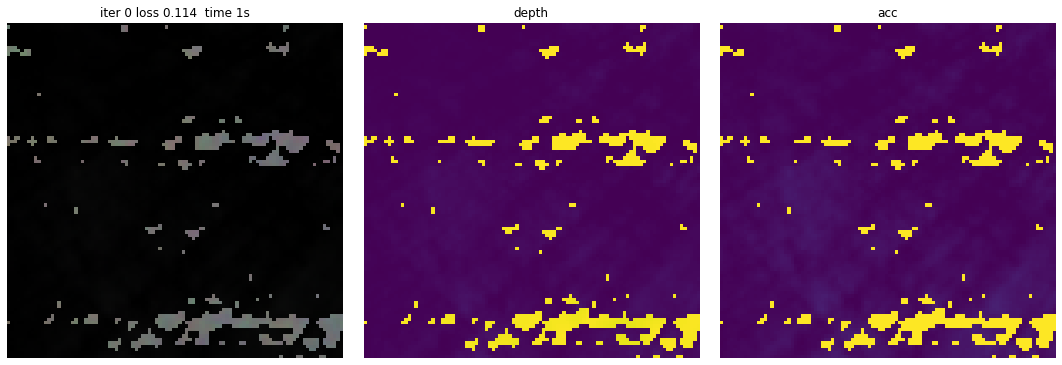

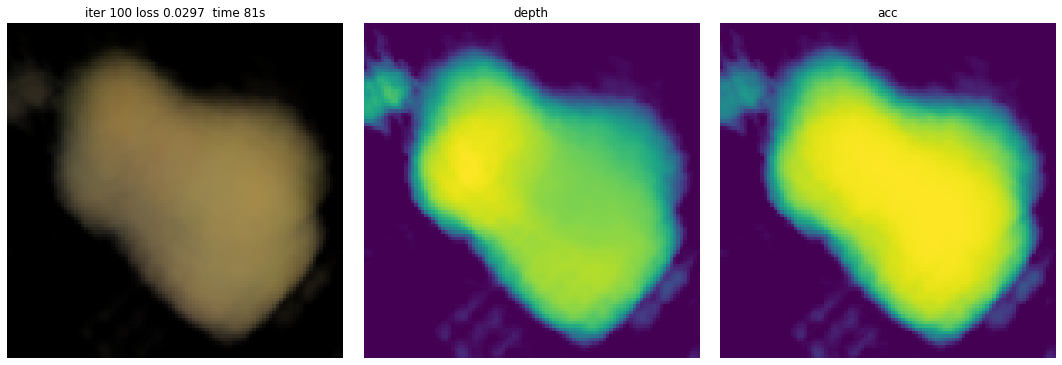

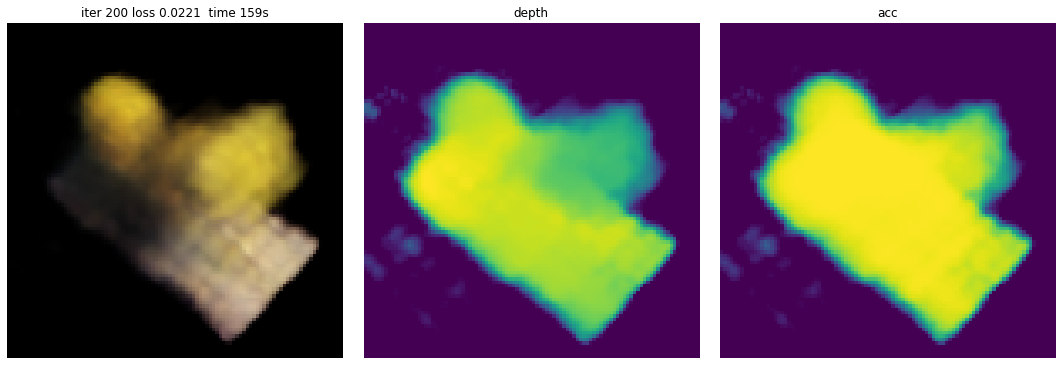

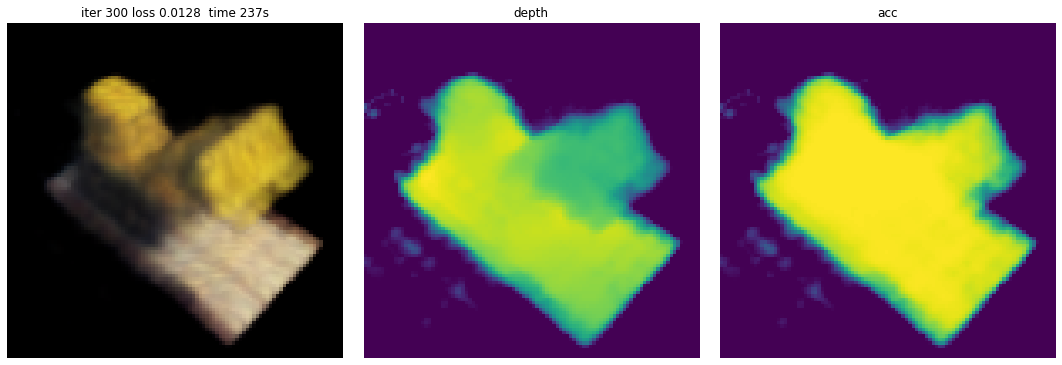

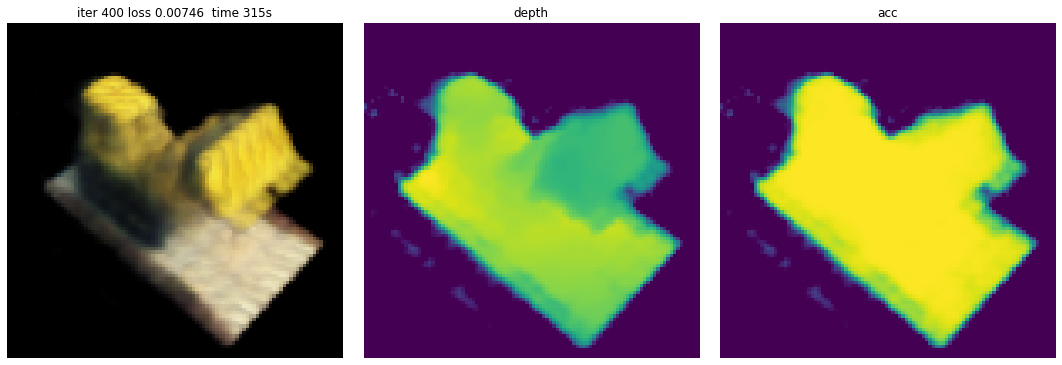

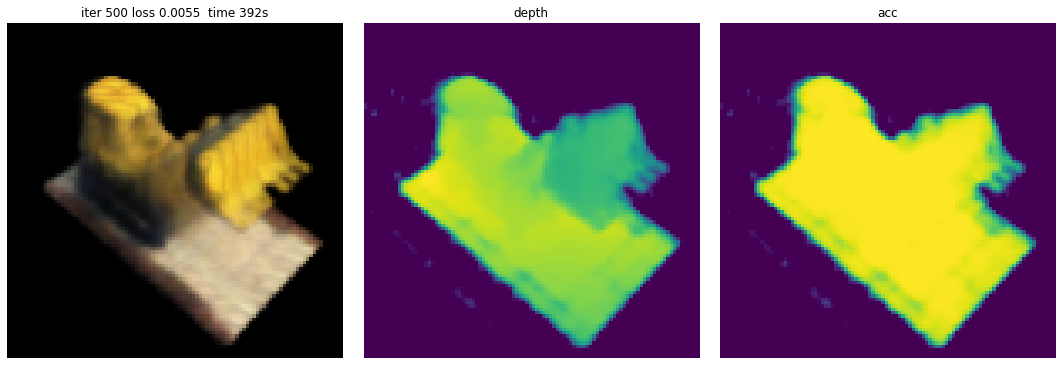

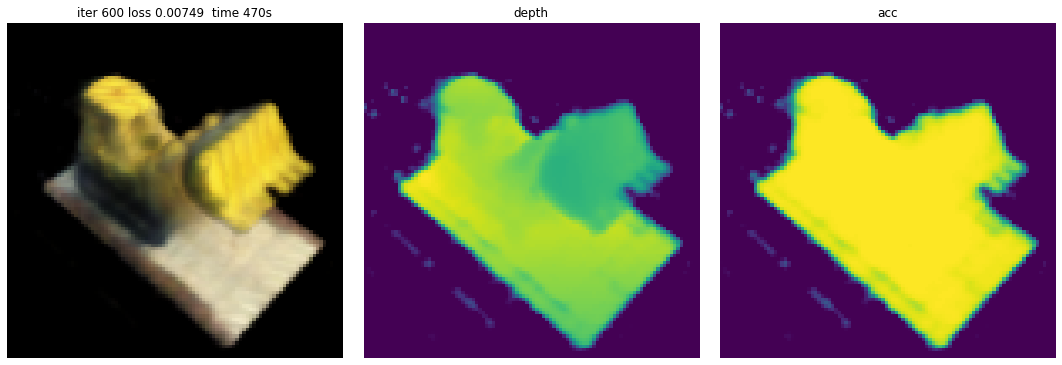

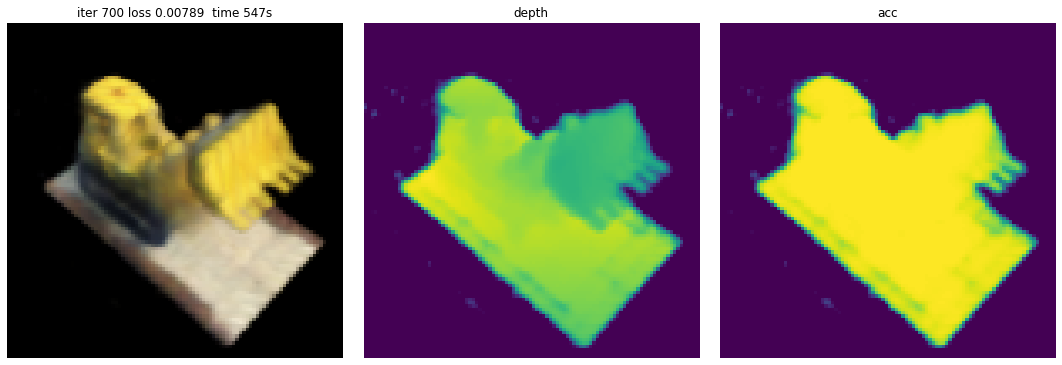

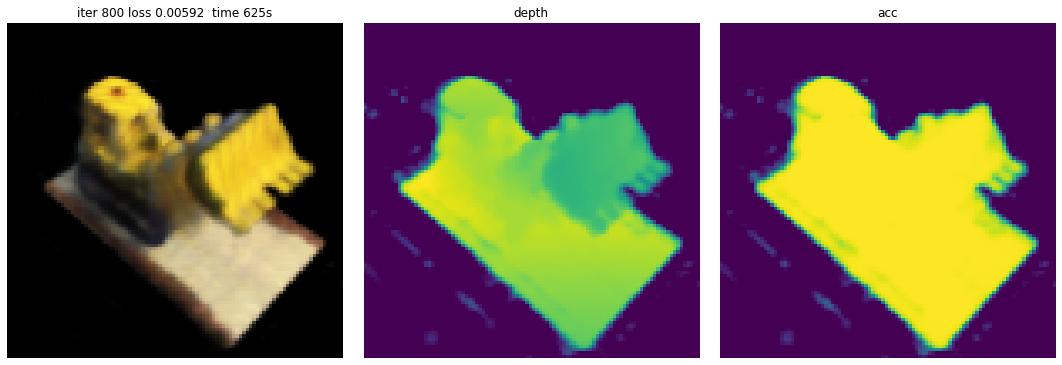

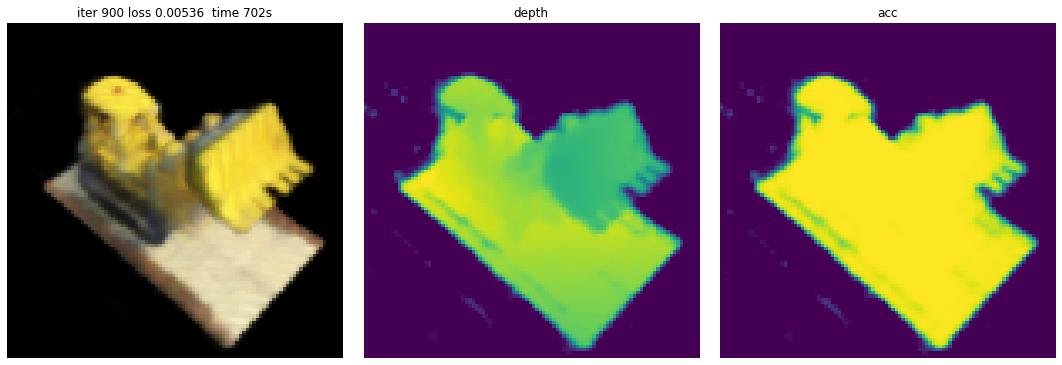

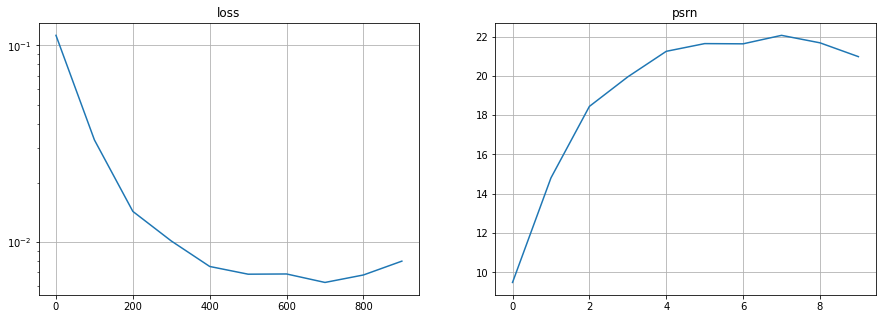

In [10]:
t = time.time()
for i in range(1000):
    img_i = np.random.randint(images.shape[0])
    target = torch.tensor(images[img_i]).to(device=device)
    pose = torch.as_tensor(poses[img_i])
    rays_o, rays_d = get_rays(H, W, focal, pose)

    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True,
                                  device=device)

    optimizer.zero_grad()

    loss = ((rgb - target)**2).mean()
    loss.backward()
    optimizer.step()
    print(i, sround(loss.item(),2), "    ", end="\r")
    
    if i%i_plot == 0:
        with torch.no_grad():
            rays_o, rays_d = get_rays(H, W, focal, torch.as_tensor(testpose))
            rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
            rgb = rgb.cpu().clone().detach()
            losses.append(((rgb - torch.tensor(testimg))**2).mean())
            iternums.append(i)

            plt.figure(figsize=(15,5))
            plt.subplot(131)
            plt.title(f"iter {i} loss {sround(loss.item(),2)}  time {int(time.time()-t)}s")
            plt.imshow(rgb.numpy())
            plt.axis("off")
            
            plt.subplot(132)
            plt.title("depth")
            plt.imshow(depth.cpu().clone().detach().numpy())
            plt.axis("off")

            plt.subplot(133)
            plt.title("acc")
            plt.imshow(acc.cpu().clone().detach().numpy())
            plt.axis("off")
            plt.tight_layout()
            plt.show()

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("loss")
plt.plot(iternums, losses)
plt.yscale("log")
plt.grid()

plt.subplot(122)
plt.title("psrn")
plt.plot(-10. *np.log10(np.array([l.item() for l in losses])))
plt.grid()
plt.show()

## Inspect rendering

In [147]:
def depth_samples(near, far, N_samples, rand=True, verbose=False):
    # sample template
    z_vals = torch.linspace(near, far, N_samples)

    # jitter sample for each ray
    if rand:
        z_vals = z_vals + torch.rand(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    if verbose:
        print("jittered depth sampling, z_vals\n", z_vals)
    return z_vals

def project_samples(origin, direction, samples, verbose=False):
    pts = origin[...,None,:] + direction[...,None,:] * samples[...,:,None]
    if verbose:
        print("projected directions\n", pts.shape)
    return pts

def render_rays_verb(network_fn, rays_o, rays_d, near, far, N_samples, rand=False, device="cuda",verbose=[0,0,1]):

    z_vals = depth_samples(near, far, N_samples, rand=rand, verbose=verbose[0])

    # global jittered samples
    pts = project_samples(rays_o, rays_d, z_vals, verbose=verbose[1])
    
    # embed, global x,y,z samples per ray to sin(x), cos(x), sin(2x), cos(2x), ...cos(x*2**i), sin(y)...
    pts_flat = embed_fn(pts.reshape(-1,3)).to(device=device)
    if verbose[2]:
        print("embeded samples\n", pts_flat)
    
    # run model in batches
    step = 32*1024
    raw = torch.cat([network_fn(pts_flat[i:i+step])
                     for i in range(0, len(pts_flat), step)]).view(list(pts.shape[:-1]) + [4])

    # Compute opacities and colors, model outputs rgba predictions
    sigma_a = nn.ReLU()(raw[...,3])
    rgb = nn.Sigmoid()(raw[...,:3]) 
                      
    # Do volume rendering
    # depth steps per ray
    dists = torch.cat([z_vals[..., 1:] - z_vals[..., :-1],
                       torch.full(z_vals[...,:1].shape, 1e10)], -1).to(device=device)

    # alpha values 
    alpha = 1.-torch.exp(-sigma_a * dists)
    weights = alpha * exclusive_cumprod(1.-alpha + 1e-10)
    
    # sum up rgb values along ray
    rgb_map = torch.sum(weights[...,None] * rgb, -2) 
    depth_map = torch.sum(weights * z_vals.to(device=device), -1) 
    acc_map = torch.sum(weights, -1)

    return rgb_map, depth_map, acc_map

In [148]:
rays_o, rays_d = get_rays(H, W, focal, torch.as_tensor(testpose))
rays_o.shape, rays_d.shape

(torch.Size([100, 100, 3]), torch.Size([100, 100, 3]))

## compare single rays

In [149]:
## origin is the same for all rays
rayo = rays_o[:1, :1, :]
rayd0 = rays_d[:1, :1, :]
rayd1 = rays_d[50:51, 50:51, :]
rayo, rayd0, rayd1

(tensor([[[-1.9745, -1.8789,  2.9700]]]),
 tensor([[[ 0.4338,  0.9097, -0.4933]]]),
 tensor([[[ 0.4898,  0.4661, -0.7368]]]))

In [151]:
rayd = rayd1
print("from", rayo, "along", rayd)

with torch.no_grad():
    rgb0, depth0, acc0 = render_rays_verb(model, rayo, rayd, near=2., far=6., N_samples=N_samples, verbose=[0,1,1])

from tensor([[[-1.9745, -1.8789,  2.9700]]]) along tensor([[[ 0.4898,  0.4661, -0.7368]]])
projected directions
 torch.Size([1, 1, 64, 3])
embeded samples
 tensor([[-9.9489e-01, -9.4672e-01,  1.4965e+00,  ...,  9.1281e-01,
          4.3494e-01, -7.2291e-01],
        [-9.6379e-01, -9.1713e-01,  1.4497e+00,  ...,  8.3945e-01,
         -4.7682e-01, -7.4242e-01],
        [-9.3269e-01, -8.8753e-01,  1.4029e+00,  ...,  1.0803e-03,
         -9.9198e-01,  6.1331e-01],
        ...,
        [ 9.0220e-01,  8.5851e-01, -1.3570e+00,  ..., -8.2758e-01,
         -6.9537e-01,  8.4870e-01],
        [ 9.3330e-01,  8.8811e-01, -1.4038e+00,  ...,  2.0408e-02,
         -9.8948e-01,  5.9009e-01],
        [ 9.6440e-01,  9.1770e-01, -1.4506e+00,  ...,  8.4980e-01,
         -4.6057e-01, -7.6158e-01]], device='cuda:0')


In [152]:
    z_vals = depth_samples(near=2., far=6., N_samples=N_samples, rand=True, verbose=False)
    # global jittered samples
    pts = project_samples(rayo, rayd, z_vals, verbose=False)

In [153]:
z_vals = depth_samples(near=2., far=6., N_samples=N_samples, rand=True, verbose=False)
print(z_vals.shape)
z_vals= z_vals[[0,50,99], 50:51, :]
rayd2 = rays_d[[0,50,99], 50:51, :]
rayo2 = rays_o[[0,50,99], 50:51, :]
pts = project_samples(rayo2, rayd2, z_vals, verbose=False)

raytext = ["0,50", "50,50", "99,50"]
pts.shape

torch.Size([100, 100, 64])


torch.Size([3, 1, 64, 3])

In [53]:
! pip install plotly

In [154]:
pts.shape

torch.Size([3, 1, 64, 3])

In [109]:
pts_flat = embed_fn(pts.reshape(-1,3))#.to(device=device)
pts_flat.shape 

torch.Size([192, 39])

# Visualize sampling of ray subset

In [106]:
import plotly.graph_objs as go
def scatter_points(points, size=2, text=""):
  return go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers+text',
    marker=dict(size=size),
    text=text,
    textposition="top center"
  )
data= [scatter_points(rays_o[0,0].cpu().detach().view(-1,3).numpy(), size=10, text=["camera"])]

data += [ scatter_points(pt.cpu().detach().view(-1,3).numpy(), text=[f"ray[{raytext[i]}]"]) for i, pt in enumerate(pts)]

fig = go.Figure(data)
fig.update_layout(scene_dragmode='orbit', title='Depth Sampling in NeRF')
fig.show()

# Visualize positional embedding

In [122]:
pts_flat0 = embed_fn(pts[0].reshape(-1,3))#.to(device=device)
print("sample ray", tuple(pts[0].shape))
print("embedded ray", tuple(pts_flat0.shape))
print("flat points: x, sin(x*2**0),...,sin(x*2**5): 6*2*3", 6*2*3 + 3)

sample ray (1, 64, 3)
embedded ray (64, 39)
flat points: x, sin(x*2**0),...,sin(x*2**5): 6*2*3 39


In [126]:
print("ray, x", pts[0][...,0])

ray, x tensor([[-0.6024, -0.5416, -0.5035, -0.4548, -0.4241, -0.3540, -0.3466, -0.2851,
         -0.2444, -0.2203, -0.1750, -0.1101, -0.0662, -0.0344,  0.0107,  0.0718,
          0.0846,  0.1543,  0.1973,  0.2127,  0.2647,  0.3149,  0.3732,  0.4254,
          0.4314,  0.5118,  0.5242,  0.5966,  0.6432,  0.6702,  0.7294,  0.7459,
          0.7826,  0.8233,  0.9033,  0.9128,  0.9599,  1.0318,  1.0535,  1.1093,
          1.1310,  1.1692,  1.2186,  1.2784,  1.3199,  1.3594,  1.3889,  1.4533,
          1.5041,  1.5472,  1.5724,  1.6335,  1.6778,  1.7243,  1.7361,  1.7847,
          1.8235,  1.8962,  1.9062,  1.9533,  2.0045,  2.0555,  2.0957,  2.1387]])


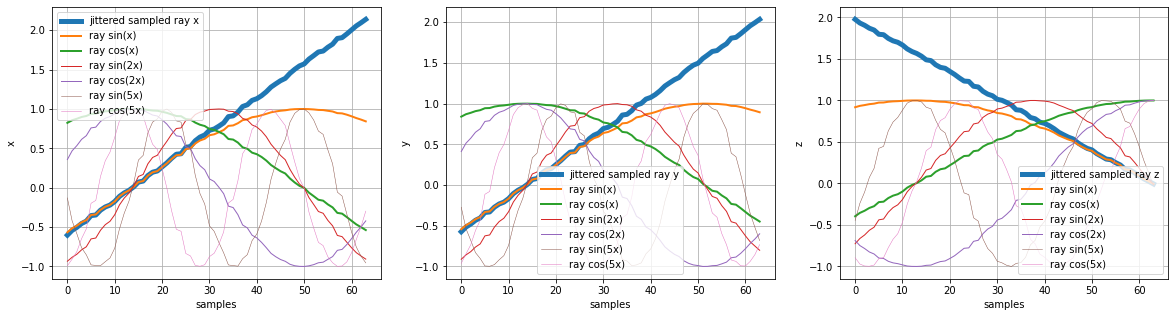

In [144]:
def plot_ray(x, name="x"):
    plt.plot(x, label=f"jittered sampled ray {name}", linewidth="5")
    plt.plot(np.sin(x), label="ray sin(x)", linewidth="2")
    plt.plot(np.cos(x), label="ray cos(x)", linewidth="2")
    plt.plot(np.sin(2*x), label="ray sin(2x)", linewidth="1")
    plt.plot(np.cos(2*x), label="ray cos(2x)", linewidth="1")
    plt.plot(np.sin(5*x), label="ray sin(5x)", linewidth="0.5")
    plt.plot(np.cos(5*x), label="ray cos(5x)", linewidth="0.5")
    plt.xlabel("samples")
    plt.ylabel(name)
    plt.grid()
    plt.legend()

plt.figure(figsize=(20,5))
plt.subplot(131)
x = pts[0][...,0].view(-1).clone().detach().numpy()
plot_ray(x)
plt.subplot(132)
y = pts[0][...,1].view(-1).clone().detach().numpy()
plot_ray(y, "y")
plt.subplot(133)
z = pts[0][...,2].view(-1).clone().detach().numpy()
plot_ray(z, "z")

plt.show()

# render 3 pixels, 2 corners (transparent), center (yellow)

In [155]:
# network inputs, 64 samples, 3 channels + 6 sin channels + 6 cos channels
pts_flat.shape 

torch.Size([192, 39])

In [157]:
# run model on 3 rays
raw = model(pts_flat.cuda()).view(list(pts.shape[:-1]) + [4])

# Compute opacities and colors, model outputs rgba predictions
sigma_a = nn.ReLU()(raw[...,3])
rgb = nn.Sigmoid()(raw[...,:3]) 

In [158]:
sigma_a.shape, rgb.shape

(torch.Size([3, 1, 64]), torch.Size([3, 1, 64, 3]))

## model result: alphas are clamped, 0 = translarent

In [200]:
dists = torch.cat([z_vals[..., 1:] - z_vals[..., :-1],
                       torch.full(z_vals[...,:1].shape, 1e10)], -1)#.to(device=device)
dists.device

device(type='cpu')

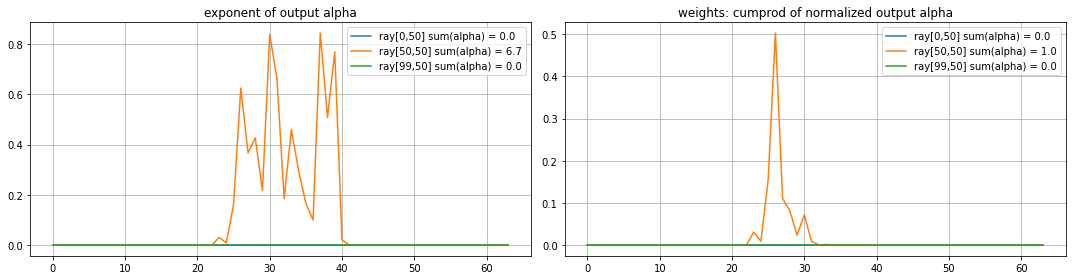

In [222]:
sigmas = sigma_a.cpu().clone().detach()

alphas = 1.-torch.exp(-sigmas * dists)
weights = alphas * exclusive_cumprod(1.-alphas + 1e-10).cpu().clone().detach()

plt.figure(figsize=(15,4))
plt.title("sigma and alpha for 3 rays")
plt.subplot(121)
plt.title("exponent of output alpha")
for i, alpha in enumerate(alphas):
    plt.plot(alpha.view(-1).numpy(), label=f"ray[{raytext[i]}] sum(alpha) = {round(alpha.sum().item(),1)}")
plt.grid()
plt.legend()
plt.tight_layout()

plt.subplot(122)
plt.title("weights: cumprod of normalized output alpha")
for i, alpha in enumerate(weights):
    plt.plot(alpha.view(-1).numpy(), label=f"ray[{raytext[i]}] sum(alpha) = {round(alpha.sum().item(),1)}")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## model result: rgbs are added over sigmoid, rgb on non transparent pixel

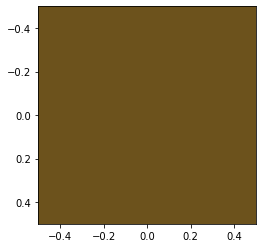

(1, 3)

In [212]:
# Resulting color of pixel at [50,50]
rgb_map = torch.sum(weights[1][...,None].cpu() * rgb[1].cpu(), -2).clone().detach().numpy()
plt.imshow(rgb_map.reshape(1,1,3))
plt.show()

In [220]:
wgts = weights[1][...,None].cpu() * rgb[1].cpu().clone().detach().numpy().reshape(64,3)
wgts.shape

torch.Size([1, 64, 3])

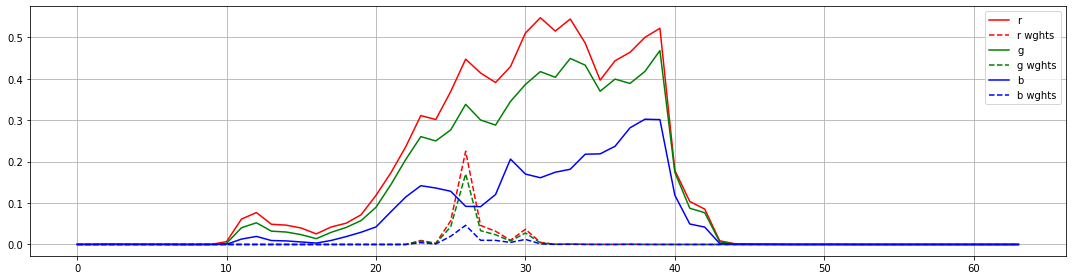

In [221]:
rgbs = rgb.cpu().clone().detach()[1]
wgts = weights[1][...,None].cpu() * rgb[1].cpu().clone().detach().numpy()#.reshape(64,3)

rgbs.shape, rgbs[...,0].shape
channels = ['r','g','b']
plt.figure(figsize=(15,4))
for i, channel in enumerate(channels):
    plt.plot(rgbs[0][...,i], label=channel, color=channel)

    plt.plot(wgts[0][...,i], label=f"{channel} wghts", color=channel, linestyle="--")
plt.grid()
plt.legend()
# plt.axis("off")
plt.tight_layout()
plt.show()
plt.figure(figsize=(15,1))
plt.imshow(rgbs.numpy())
plt.axis("off")
plt.tight_layout()
plt.show()
